## Loading the packages

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import sys

import pandas as pd
from ipywidgets import interact, widgets
import os

%matplotlib inline

In [2]:
PATH = '../vowels'

from python_speech_features import mfcc
import scipy.io.wavfile as wav

import glob
nam_paths = glob.glob(os.path.join(PATH, 'nam*.wav'))
naf_paths = glob.glob(os.path.join(PATH, 'naf*.wav'))
nk_paths = glob.glob(os.path.join(PATH, 'nk*.wav'))

# Imports Dataset

In [22]:
# Here we read the wave files and store their content in lists
naf_audios = [wav.read(path) for path in naf_paths]
nam_audios = [wav.read(path) for path in nam_paths]
nk_audios = [wav.read(path) for path in nk_paths]

# Import medians of the mfcc
naf_mfcc_median = np.array([np.median(mfcc(x, samplerate=sample_rate, nfft=1024), axis=0) for sample_rate, x in naf_audios])
nam_mfcc_median = np.array([np.median(mfcc(x, samplerate=sample_rate, nfft=1024), axis=0) for sample_rate, x in nam_audios])
nk_mfcc_median = np.array([np.median(mfcc(nam[1], nam[0], nfft=1024), axis=0) for nam in nk_audios])# ...

# Analyze Data and normalization

## Exporation

In [5]:
print("Number of male samples: %s" % len(nam_audios))
print("Number of female samples: %s" % len(naf_audios))
print("Number of kids samples: %s" % len(nk_audios))

Number of male samples: 36
Number of female samples: 36
Number of kids samples: 108


Contrairement à l'expérience 1, Ici on observe beaucoup plus de données pour les enfants. Notre dataset est imbalanced !

Dans une situation normale notre première réaction serait de récolter plus de données d'hommes et de femmes, mais ce n'est pas possible pour ce laboratoire.

Nous avons donc 2 choix possibles pour résoudre ce problème. Over-sampler les classes sousreprésentées ou Under-sampler la classe surreprésentée.
Étant donnée que le dataset à déjà un petit nombre de données, on va préférer l'over-sampling.

## Classes
Pour cette expérience nous avons 3 classes, femme, homme et enfant, que nous avons codifié comme :
* Homme => [1, 0, 0]
* Femme => [0, 1, 0]
* Enfant => [0, 0, 1]

In [23]:
naf_mfcc_median = np.append(naf_mfcc_median, [[1, 0, 0]] * len(naf_mfcc_median), axis=1)
nam_mfcc_median = np.append(nam_mfcc_median, [[0, 1, 0]] * len(nam_mfcc_median), axis=1)
nk_mfcc_median = np.append(nk_mfcc_median, [[0, 0, 1]] * len(nk_mfcc_median), axis=1)

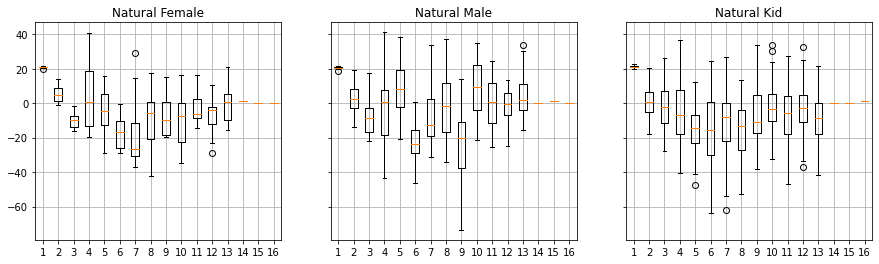

In [65]:
f, (ax1, ax2, ax3) = pl.subplots(1,3, sharey='all', figsize=(15,4))
ax1.plot()
ax1.boxplot(naf_mfcc_median)
ax1.set_title('Natural Female')
ax1.grid()
ax2.boxplot(nam_mfcc_median)
ax2.set_title('Natural Male')
ax2.grid()
ax3.boxplot(nk_mfcc_median)
ax3.set_title('Natural Kid')
ax3.grid()

In [26]:
from imblearn.over_sampling import RandomOverSampler
# Dataset with all the classes
df_mfcc = np.append(np.append(naf_mfcc_median, nam_mfcc_median, axis=0), nk_mfcc_median, axis=0)

# Oversample the two less prevalent classes
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(df_mfcc[:, :13], df_mfcc[:, 13:])

df_mfcc =  np.append(X_resampled, y_resampled, axis=1)

nb_m = 0
nb_f = 0
nb_k = 0

for x in df_mfcc[:, 13:]:
    if (x == [1, 0, 0]).all():
        nb_m = nb_m + 1
    if (x == [0, 1, 0]).all():
        nb_f = nb_f + 1
    if (x == [0, 0, 1]).all():
        nb_k = nb_k + 1

print("Number of male samples: %s" % nb_m)
print("Number of female samples: %s" % nb_f)
print("Number of kids samples: %s" % nb_k)

Number of male samples: 108
Number of female samples: 108
Number of kids samples: 108


On peut voir maintenant que les classes ont toutes le même nombre de données.

## Normalisation
On peut voir que nos variables ne sont pas normalisées. Pour améliorer la rapidité de l'entrainement nous allons les amener à la même echelle [0,1]

In [27]:
from sklearn.preprocessing import MinMaxScaler

inputs = df_mfcc[:, :13]

# Normalization of the inputs
df_mfcc = np.append(MinMaxScaler().fit_transform(inputs), df_mfcc[:, 13:], axis=1)

df_mfcc = pd.DataFrame(df_mfcc, columns=[*range(1, 14)] + ['male'] + ['female'] + ['kid'])

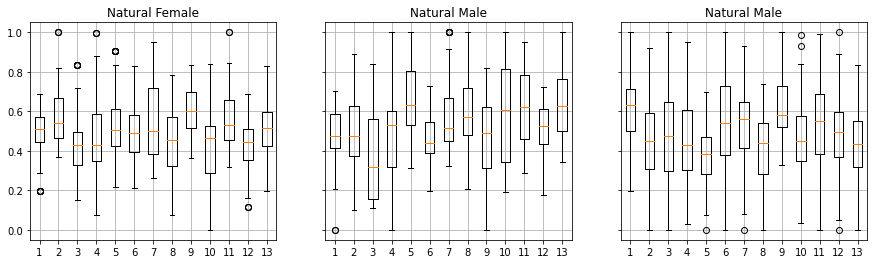

In [30]:
f, (ax1, ax2, ax3) = pl.subplots(1,3, sharey='all', figsize=(15,4))
ax1.plot()
ax1.boxplot(df_mfcc.loc[df_mfcc['male'] == 1].loc[:, :13])
ax1.set_title('Natural Female')
ax1.grid()
ax2.boxplot(df_mfcc.loc[df_mfcc['female'] == 1].loc[:, :13])
ax2.set_title('Natural Male')
ax2.grid()
ax3.boxplot(df_mfcc.loc[df_mfcc['kid'] == 1].loc[:, :13])
ax3.set_title('Natural Male')
ax3.grid()


# MLP

## Exploring the number of epochs and hyper parameters

Nous faisons un premier entrainement avec des hyper-parametres "standard" pour estimer la complexité du problème

In [49]:
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

# Hyper parameters...
N_INITS = 10
EPOCHS = 200
N_NEURONS = [1, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

            1         2         3         4         5         6         7  \
0    0.524889  0.763100  0.329463  0.291379  0.468601  0.582105  0.800963   
1    0.638077  0.537640  0.326401  0.547324  0.442770  0.556830  0.388078   
2    0.660313  0.760234  0.360723  0.289452  0.216615  0.486020  0.950593   
3    0.503912  0.448196  0.465196  0.740600  0.610137  0.426680  0.275340   
4    0.688700  0.461649  0.259941  0.671106  0.498248  0.394406  0.293725   
..        ...       ...       ...       ...       ...       ...       ...   
319  0.588107  0.369946  0.113610  0.666223  0.665413  0.493558  0.451804   
320  0.575078  0.411019  0.214318  0.699866  0.922330  0.454874  0.388838   
321  0.452239  0.394682  0.436885  0.226111  0.514634  0.534221  0.623205   
322  0.433218  0.542716  0.599544  0.230781  0.551758  0.407425  0.658652   
323  0.374332  0.351753  0.637777  1.000000  0.746439  0.403217  0.476418   

            8         9        10        11        12        13  
0    0.78

In [47]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,3], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()
        MSE[i_h, i, :] = nn.fit((df_mfcc.loc[:, :13], df_mfcc.loc[:, ['male', 'female', 'kid']]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


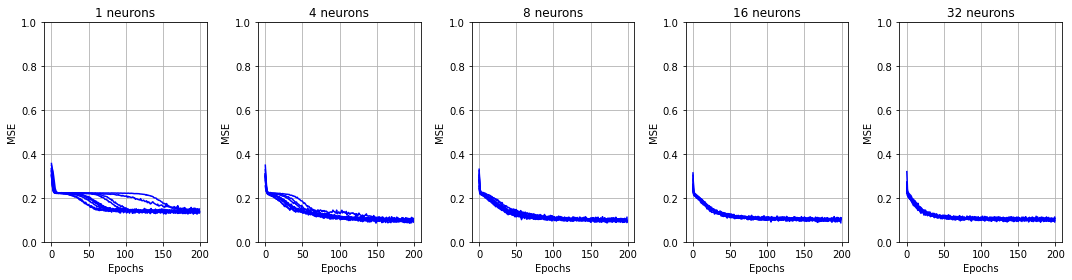

In [48]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

On peut voir que l'erreur ne diminue pas de manière significative après ~100 Epochs peu importe le nombre de neurones dans la couche cachée.
Un learning rate de 0.001 et un momentum de 0.5 donne des résultats qui semblent acceptables. Nous les utiliserons comme base.

## Hyper parameter tuning

In [50]:
def train_model(dataframe, k, n_tests, n_inits, epochs, n_neurons, learning_rate, momentum):
    MSE_train = np.zeros((len(n_neurons), epochs, n_tests))
    MSE_test = np.zeros((len(n_neurons), epochs, n_tests))

    for i_h, h in enumerate(n_neurons):                                     # looping the number of hidden neurons
        print('Testing', h, 'neurons...')
        nn = mlp.MLP([13,h,3], 'tanh')
        for i in np.arange(n_inits):                                        # looping the tests
            nn.init_weights()                                               # the network has to be reinitialized before each test
            temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                                dataframe,    # but cv.k_fold_cross_validation_per_epoch which
                                                                k=k,        # returns a value of error per each epoch
                                                                learning_rate=learning_rate,
                                                                momentum=momentum,
                                                                epochs=epochs)
            # temp1 and temp2 are the training and test error. One value per epoch
            MSE_train[i_h, :, i] = temp1
            MSE_test[i_h, :, i] = temp2
    return MSE_train, MSE_test

In [51]:
def plot_model_perf(MSE_train, MSE_test, n_neurons, filename=None):
    MSE_train_mean = np.mean(MSE_train, axis=2)
    MSE_test_mean = np.mean(MSE_test, axis=2)
    MSE_train_sd = np.std(MSE_train, axis=2)
    MSE_test_sd = np.std(MSE_test, axis=2)

    v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
    v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

    n_rows = int(np.ceil(len(n_neurons)/3.0))
    pl.figure(figsize=(12,3*n_rows))
    for i_n, n in enumerate(n_neurons):
        pl.subplot(n_rows, min(3, len(n_neurons)), i_n+1)
        pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
        pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
        pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
        pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
        pl.ylim(0.95*v_min,0.5*v_max)
        pl.ylabel('MSE')
        pl.xlabel('Number of epochs')
        pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
        pl.legend()
        pl.grid()
    pl.tight_layout()
    if filename is not None:
        pl.savefig('../output/xp2/' + filename + '.png', dpi=500)

Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


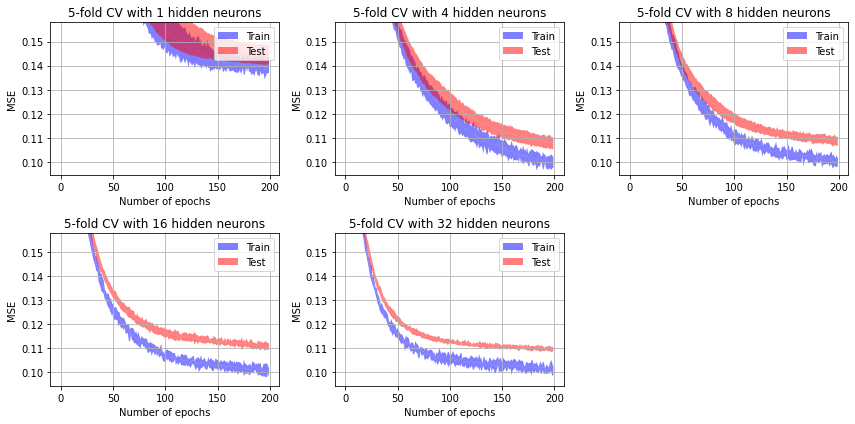

In [52]:
K = 5
N_TESTS = 10

# Hyper parameters...
N_INITS = 10
EPOCHS = 200
N_NEURONS = [1, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

MSE_train, MSE_test = train_model(df_mfcc.to_numpy(), K, N_TESTS, N_INITS, EPOCHS, N_NEURONS, LEARNING_RATE, MOMENTUM)
plot_model_perf(MSE_train, MSE_test, N_NEURONS, 'perf_epoch_' + str(EPOCHS) + '_lr_' + str(LEARNING_RATE) + '_m_'+ str(MOMENTUM))

On essaie un grand ensemble d'hyper paramètre

In [53]:
K = 5
N_TESTS = 10

# Hyper parameters...
N_INITS = 10
EPOCHS = 300
N_NEURONS = [1, 4, 8, 16, 32]
LEARNING_RATE = [0.2, 0.01, 0.0075, 0.005, 0.0025, 0.001, 0.0005]
MOMENTUM = [0.3, 0.4, 0.5, 0.7, 0.8, 0.9]

MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

data = []
cnt = 0
for lr in LEARNING_RATE:
    for mom in MOMENTUM:
        cnt = cnt + 1
        print(cnt, " | learning rate: ", lr , " - momentum: ", mom)
        MSE_train, MSE_test = train_model(df_mfcc.to_numpy(), K, N_TESTS, N_INITS, EPOCHS, N_NEURONS, lr, mom)
        MSE_test_mean = np.mean(MSE_test, axis=2)
        for n_i, n in enumerate(N_NEURONS):
            data.append([lr, mom, n, np.min(MSE_test_mean[n_i])])

1  | learning rate:  0.2  - momentum:  0.3
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
2  | learning rate:  0.2  - momentum:  0.4
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
3  | learning rate:  0.2  - momentum:  0.5
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
4  | learning rate:  0.2  - momentum:  0.7
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
5  | learning rate:  0.2  - momentum:  0.8
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
6  | learning rate:  0.2  - momentum:  0.9
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
7  | learning rate:  0.01  - momentum:  0.3
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neur

In [54]:
df_data = pd.DataFrame(data, columns=['learning_rate', 'momentum', 'n_neurons', 'min_MSE'])
print(df_data.sort_values('min_MSE'))

    learning_rate  momentum  n_neurons   min_MSE
56         0.0100       0.9          4  0.040894
57         0.0100       0.9          8  0.040898
58         0.0100       0.9         16  0.041086
88         0.0075       0.9         16  0.041148
53         0.0100       0.8         16  0.042060
..            ...       ...        ...       ...
23         0.2000       0.8         16  0.663523
27         0.2000       0.9          8  0.675557
24         0.2000       0.8         32  0.718972
28         0.2000       0.9         16  0.783528
29         0.2000       0.9         32  0.906747

[210 rows x 4 columns]


La paire d'hyper paramètres (learning rate = 0.01, momentum = 0.9) semble clairement être le meilleur compromi. Et offre les meilleurs résultats peut importe le nombre de neurone.

<AxesSubplot:xlabel='momentum', ylabel='learning_rate'>

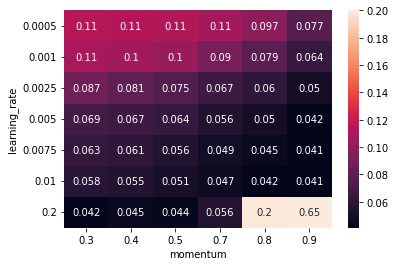

In [55]:
import seaborn as sns

df_wide = df_data.pivot_table( index='learning_rate', columns='momentum', values='min_MSE', aggfunc=min)
sns.heatmap(df_wide, annot=True, vmax=0.2)

In [56]:
best_hyper_params = df_data.sort_values('min_MSE').head()
best_hyper_params

,learning_rate,momentum,n_neurons,min_MSE
56,0.0100,0.9,4,0.040894
57,0.0100,0.9,8,0.040898
58,0.0100,0.9,16,0.041086
88,0.0075,0.9,16,0.041148
53,0.0100,0.8,16,0.042060


Nous allons maintenant tester une par une les combinaisons qui nous ont données les meilleurs résultats. Et voir leur nombre d'epochs optimale

Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 16 neurons...
Testing 16 neurons...


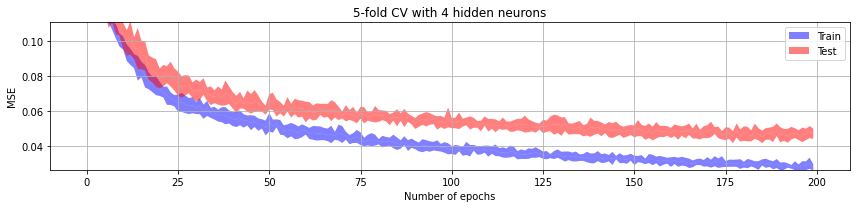

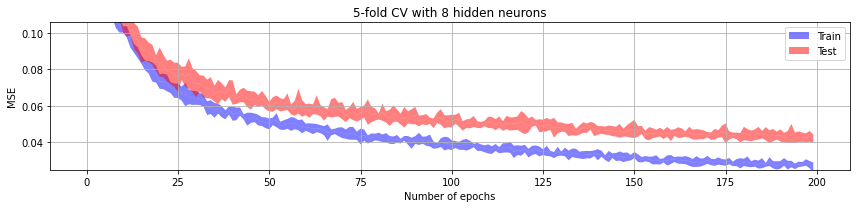

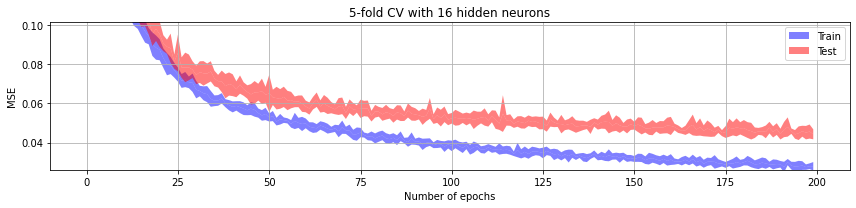

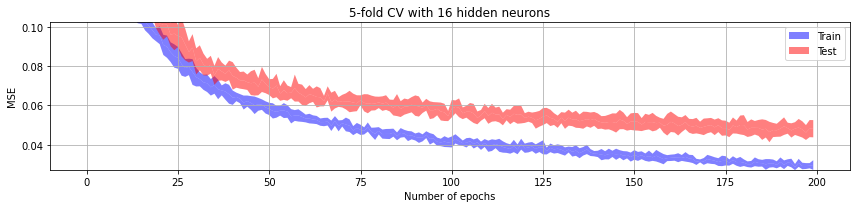

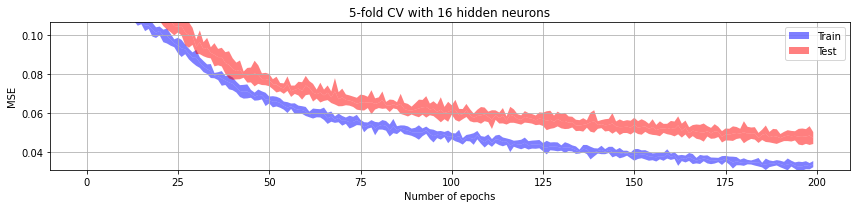

In [57]:
K = 5
N_TESTS = 10
N_INITS = 10
EPOCHS = 200

for index, row in best_hyper_params.iterrows():
    MSE_train, MSE_test = train_model(df_mfcc.to_numpy(), K, N_TESTS, N_INITS, EPOCHS, [int(row['n_neurons'])], row['learning_rate'], row['momentum'])
    plot_model_perf(MSE_train, MSE_test, [int(row['n_neurons'])], 'perf_epoch_' + str(EPOCHS) + '_lr_' + str(row['learning_rate']) + '_m_'+ str(row['momentum']))

Les résultats sont très similaire et tout les modèles pourrait être adéquat mais nous allons choisir la solution 0.01 learning rate, 0.9 momentum et 4 neurones dans la couche cachée car elle est moins couteuse computationnellement.


## Final model

Notre modèle final aura donc 4 neurones, 0.01 de learning rate, un momentum de 0.9 et 200 epochs

In [58]:
nn = mlp.MLP([13,4,3], 'tanh')

EPOCHS = 200
LEARNING_RATE = 0.01
MOMENTUM = 0.9

THRESHOLD = 0.0

In [59]:
def k_fold_cross_validation_without_matrix(mlp, dataset, k=5, learning_rate=0.01, momentum=0.7, epochs=100, threshold=None):
    MSE_train_mean = 0.0
    MSE_test_mean = 0.0

    parts = cv.split_dataset(dataset, k)
    #print(parts)
    target_test = []
    output_test = []

    for k_i in np.arange(k):
        mlp.init_weights()

        training_parts = set(np.arange(k))
        training_parts.remove(k_i)
        dataset_train = np.concatenate([parts[i] for i in list(training_parts)])
        dataset_test = parts[k_i]

        input_data = dataset_train[:,0:mlp.n_inputs]
        output_data = dataset_train[:,mlp.n_inputs:(mlp.n_inputs+mlp.n_outputs)]
        input_data_test = dataset_test[:,0:mlp.n_inputs]
        output_data_test = dataset_test[:,mlp.n_inputs:(mlp.n_inputs+mlp.n_outputs)]

        mlp.fit((input_data, output_data),
                learning_rate=learning_rate, momentum=momentum, epochs=epochs)
        MSE_train, _ = mlp.compute_MSE((input_data, output_data))
        MSE_train_mean += MSE_train

        MSE_test, temp_out = mlp.compute_MSE((input_data_test, output_data_test))
        MSE_test_mean += MSE_test
        output_test.append(temp_out)
        target_test.append(output_data_test)

    target_test = np.concatenate(target_test, axis=0)
    output_test = np.concatenate(output_test, axis=0)

    if threshold is None:
        return (MSE_train_mean / k, MSE_test_mean / k)
    else:
        return (MSE_train_mean / k, MSE_test_mean / k, target_test, output_test)

In [60]:
N_SPLITS = 10

MSE_train = np.zeros(N_SPLITS)
MSE_test = np.zeros(N_SPLITS)

targets = []
outputs = []

for d in np.arange(N_SPLITS):
    sys.stdout.write('.')
    temp1, temp2, target, output = k_fold_cross_validation_without_matrix(nn,
                                                              df_mfcc.to_numpy(),
                                                              k=K,
                                                              learning_rate=LEARNING_RATE,
                                                              momentum=MOMENTUM,
                                                              epochs=EPOCHS,
                                                              threshold=THRESHOLD)

    MSE_train[d] = temp1
    MSE_test[d] = temp2
    targets.append(target)
    outputs.append(output)

targets = np.concatenate(targets, axis=0)
outputs = np.concatenate(outputs, axis=0)

..........

In [69]:
print(outputs)

[[ 0.32731408  0.01810573  0.82780899]
 [-0.03978733  0.94872134  0.02839235]
 [ 0.9158219  -0.10181676 -0.03731731]
 ...
 [ 0.76019542  0.14521629  0.40556235]
 [ 0.03705937  0.95411107  0.08607917]
 [-0.48036594  0.60871876  0.94692261]]


In [75]:
def predicted_class(output):
    CLASSES = ['male', 'female', 'kid']
    pred = 0
    for i in range(1, len(CLASSES)):
        if output[pred] < output[i]:
            pred = i
    return CLASSES[pred]


y_pred = [predicted_class(y) for y in outputs.tolist()]
y_true = [predicted_class(y) for y in targets.tolist()]

import sklearn.metrics as metrics



conf_mat = metrics.confusion_matrix(y_true, y_pred, labels=['male', 'female', 'kid'])

In [76]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  [0.0291216  0.02953071 0.03154893 0.03327632 0.02743744 0.02806219
 0.02954118 0.02847257 0.03774781 0.03010667]
MSE test:  [0.04878    0.04532136 0.04486062 0.04250371 0.04213399 0.04545221
 0.04355669 0.04599137 0.0465086  0.04907556]
Confusion matrix:
[[1041   12   27]
 [   3 1077    0]
 [ 137   12  931]]


Calcul des performances...

Accuracy:  0.9410493827160494
F1-Score:  0.9410493827160494
Recall 0.9410493827160494


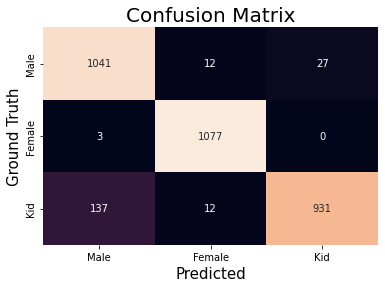

In [85]:

# Rows are the actual class and columns are the predicted class
print("Accuracy: ", metrics.accuracy_score(y_true, y_pred))
print("F1-Score: ", metrics.f1_score(y_true, y_pred, average='micro'))
print("Recall", metrics.recall_score(y_true, y_pred, average='micro'))

classes = np.array(['Male', 'Female', 'Kid'])
ax = sns.heatmap(conf_mat, annot=True, cbar=False, fmt=".4g", xticklabels=classes, yticklabels=classes)
pl.title('Confusion Matrix', fontsize = 20) # title with fontsize 20
pl.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
pl.ylabel('Ground Truth', fontsize = 15) # y-axis label with fontsize 15

pl.show()

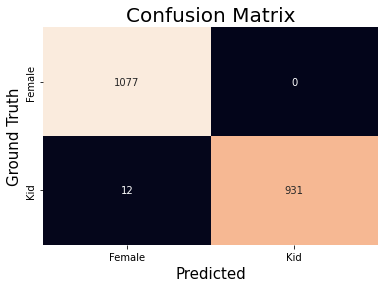

In [87]:
ax = sns.heatmap(conf_mat[1:,1:], annot=True, cbar=False, fmt=".4g", xticklabels=classes[1:], yticklabels=classes[1:])
pl.title('Confusion Matrix', fontsize = 20) # title with fontsize 20
pl.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
pl.ylabel('Ground Truth', fontsize = 15) # y-axis label wth fontsize 15

pl.show()